<a href="https://colab.research.google.com/github/amarsinghen/amazon-reviews-sentiment-analysis/blob/master/amazon_reviews_sentiment_analysis_data_model_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [ ]:
!pip install contractions

     |████████████████████████████████| 317kB 4.7MB/s 
     |████████████████████████████████| 245kB 20.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81693 sha256=f0d65814312553006d8812c3b3258f008420ce4bb52785401d3925809e363b40
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bz2
import gc
import re
import os
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata
import spacy
from bs4 import BeautifulSoup
import unicodedata
import contractions
import pickle
import gzip

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, LSTM
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm

In [ ]:
# Downloading the data from kaggle for first time, and 
# then saving to google drive for future uses. It is faster this way
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bittlingmayer/amazonreviews

 99% 489M/493M [00:19<00:00, 15.4MB/s]
100% 493M/493M [00:19<00:00, 26.7MB/s]


In [ ]:
import zipfile
local_zip = ['amazonreviews.zip']
for i in range(len(local_zip)):
    zip_ref = zipfile.ZipFile(local_zip[i], 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

In [ ]:
train_file = bz2.BZ2File('/tmp/train.ft.txt.bz2')
test_file = bz2.BZ2File('/tmp/test.ft.txt.bz2')

In [ ]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [ ]:
print(len(train_file_lines))
print(train_file_lines[:2])
print(len(test_file_lines))
print(test_file_lines[:2])

3600000
[b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n', b"__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n"]
400000
[b'__label__2

In [ ]:
# Convert from raw binary strings to strings that can be parsed
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [ ]:
print(len(train_file_lines))
print(train_file_lines[:2])
print(len(test_file_lines))
print(test_file_lines[:2])

3600000
['__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n', "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n"]
400000
['__label__2 Gr

In [ ]:
type(train_file_lines)

list

### Create Y-labels for both Train and Test

In [ ]:
one_line = '__label__1 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'
lines = ['__label__1 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n', "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n", '__label__2 Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you\'ve played the game) and the hope in "A Distant Promise" and "Girl who Stole the Star" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like "Chrono Cross ~ Time\'s Scar~", "Time of the Dreamwatch", and "Chronomantique" (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer\'s work (I haven\'t heard the Xenogears soundtrack, so I can\'t say for sure), and even if you\'ve never played the game, it would be worth twice the price to buy it.I wish I could give it 6 stars.\n', "__label__2 Excellent Soundtrack: I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners of Fate, Gale, and my girlfriend likes ZelbessDisk Three: The best of the three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, and Radical Dreamers - Unstealable Jewel.Overall, this is a excellent soundtrack and should be brought by those that like video game music.Xander Cross\n", "__label__2 Remember, Pull Your Jaw Off The Floor After Hearing it: If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Dreamers: Unstolen Jewel. (Translation varies) This music is perfect if you ask me, the best it can be. Yasunori Mitsuda just poured his heart on and wrote it down on paper.\n"]

In [ ]:
def create_labels(line):
    labels = 0 if line.split(' ')[0] == '__label__1' else 1
    return labels
print(create_labels('__label__1 Stuning even for the non-game'))

0


In [ ]:
labels = [create_labels(line) for line in lines]
print(labels)

[0, 1, 1, 1, 1]


In [ ]:
train_labels = [create_labels(line) for line in train_file_lines]
test_labels = [create_labels(line) for line in test_file_lines]
print(train_labels[:5])
print(test_labels[:5])


[1, 1, 1, 1, 1]
[1, 1, 0, 1, 1]


## Text Data Pre-Processing

### Remove labels from sentences and lowercase

In [ ]:
def remove_labels_and_lowercase(line):
    new_line = line.split(' ', 1)[1].lower()
    return new_line

In [ ]:
print(remove_labels_and_lowercase(one_line))
new_lines = [remove_labels_and_lowercase(line) for line in lines]
print(new_lines)

stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^

['stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^\n', "the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd 

In [ ]:
train_texts_list = [remove_labels_and_lowercase(line) for line in train_file_lines]
test_texts_list = [remove_labels_and_lowercase(line) for line in test_file_lines]
print(len(train_texts_list))
print(train_texts_list[:2])
print(len(test_texts_list))
print(test_texts_list[:2])

3600000
['stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^\n', "the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny.\n", 'amazing!: this soundtrack is my favorite mu

### Creating pandas dataframe

In [ ]:
train_df = pd.DataFrame({"reviews" : train_texts_list,
                        "labels" : train_labels})
test_df = pd.DataFrame({"reviews" : test_texts_list,
                        "labels" : test_labels})
print(train_df[:2])
print(test_df[:2])

                                             reviews  labels
0  stuning even for the non-gamer: this sound tra...       1
1  the best soundtrack ever to anything.: i'm rea...       1
                                             reviews  labels
0  great cd: my lovely pat has one of the great v...       1
1  one of the best game music soundtracks - for a...       1


In [ ]:
train_df["reviews_char_length"] = train_df['reviews'].str.len()
test_df["reviews_char_length"] = test_df['reviews'].str.len()
print(train_df[:2])
print(test_df[:2])

                                             reviews  ...  reviews_char_length
0  stuning even for the non-gamer: this sound tra...  ...                  427
1  the best soundtrack ever to anything.: i'm rea...  ...                  510

[2 rows x 3 columns]
                                             reviews  ...  reviews_char_length
0  great cd: my lovely pat has one of the great v...  ...                  534
1  one of the best game music soundtracks - for a...  ...                  817

[2 rows x 3 columns]


In [ ]:
train_df['reviews'].loc[:0].str.split()

0    [stuning, even, for, the, non-gamer:, this, so...
Name: reviews, dtype: object

In [ ]:
train_df["reviews_words_counts"] = train_df['reviews'].str.split().str.len()
test_df["reviews_words_counts"] = test_df['reviews'].str.split().str.len()
print(train_df[:2])
print(test_df[:2])

                                             reviews  ...  reviews_words_counts
0  stuning even for the non-gamer: this sound tra...  ...                    80
1  the best soundtrack ever to anything.: i'm rea...  ...                    97

[2 rows x 4 columns]
                                             reviews  ...  reviews_words_counts
0  great cd: my lovely pat has one of the great v...  ...                   106
1  one of the best game music soundtracks - for a...  ...                   148

[2 rows x 4 columns]


In [ ]:
train_df.describe()

,labels,reviews_char_length,reviews_words_counts
count,3600000.0,3.600000e+06,3.600000e+06
mean,0.5,4.326463e+02,7.848273e+01
std,0.5,2.375526e+02,4.283280e+01
min,0.0,7.300000e+01,2.000000e+00
25%,0.0,2.320000e+02,4.200000e+01
50%,0.5,3.840000e+02,7.000000e+01
75%,1.0,5.960000e+02,1.080000e+02
max,1.0,1.016000e+03,2.570000e+02


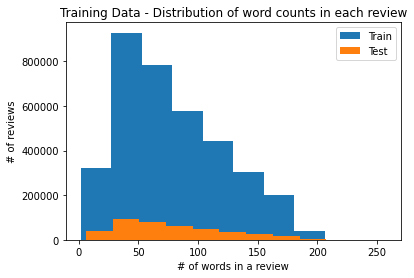

In [ ]:
plt.hist(train_df["reviews_words_counts"])
plt.hist(test_df["reviews_words_counts"])
plt.title("Training Data - Distribution of word counts in each review")
plt.xlabel("# of words in a review")
plt.ylabel("# of reviews")
plt.legend(["Train", "Test"])

In [ ]:
print("Training Data: Review with Max words - {}, Review with Min words - {}, Average # of words - {}".format(train_df["reviews_words_counts"].max(), 
                                                                                                                train_df["reviews_words_counts"].min(), 
                                                                                                                train_df["reviews_words_counts"].mean()))
print("Test Data: Review with Max words - {}, Review with Min words - {}, Average # of words - {}".format(test_df["reviews_words_counts"].max(), 
                                                                                                            test_df["reviews_words_counts"].min(),
                                                                                                            test_df["reviews_words_counts"].mean()))

Training Data: Review with Max words - 257, Review with Min words - 2, Average # of words - 78.48273333333333
Test Data: Review with Max words - 230, Review with Min words - 6, Average # of words - 78.424145


In [ ]:
max_count = 210
print("Check training data for number of reviews with >{} words: {}".format(max_count,train_df.loc[train_df["reviews_words_counts"]>max_count,"reviews_words_counts"].count()))
print("Check test data for number of reviews with >{} words : {}".format(max_count,test_df.loc[train_df["reviews_words_counts"]>max_count,"reviews_words_counts"].count()))

Check training data for number of reviews with max_acount 210 : 95
Check test data for number of reviews with max_acount 210 : 15


In [ ]:
# Checking training Quantile numbers
train_df.reviews_words_counts.quantile([0.01,0.25,0.50,0.75, 0.99])

0.01     20.0
0.25     42.0
0.50     70.0
0.75    108.0
0.99    181.0
Name: reviews_words_counts, dtype: float64

### Replacing urls with the keyword \"url\"

In [ ]:
def replace_urls(line):
    if 'www.' in line or 'http:' in line or 'https:' in line or '.com' in line:
       line = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "url", line)
    return line

In [ ]:
test_line = 'asjhdgsajhdghttphttps://www.kaggle.com/anshulra'
print(replace_urls(test_line))

url/anshulra


### Removing Html tags

In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

print(strip_html_tags('<html><h2>Some important text</h2></html>'))

Some important text


### Expanding Contractions

In [ ]:
def expand_contractions(text):
    try:
        return contractions.fix(text)
    except:
        print(text)
        pass
print(expand_contractions("Y'all can't expand contractions I'd think"))

you all can not expand contractions I would think


### Remove Accented characters

In [ ]:
def remove_accented_chars(text):
    try:
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text
    except:
        print(text)
        pass

print(remove_accented_chars('Sómě Áccěntěd těxt'))

Some Accented text


### Removing Special Characters

In [ ]:
def remove_special_characters(text, remove_digits=False):
    try:
        pattern = r'[^a-zA-z0-9\s\.,?!]' if not remove_digits else r'[^a-zA-z\s\.,?!]'
        text = re.sub(pattern, '', text)
        return text
    except:
        print(text)
        pass

remove_special_characters("Well this was fun! What do you think? 123#@! ^_.,", 
                          remove_digits=False)

'Well this was fun! What do you think? 123! ^_.,'

### Stemming

In [ ]:
def simple_stemmer(text):
    try:
        ps = nltk.porter.PorterStemmer()
        text = ' '.join([ps.stem(word) for word in text.split()])
        return text
    except:
        print(text)
        pass

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

### Lemmatization

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    try:
        text = ' '.join([wordnet_lemmatizer.lemmatize(word, pos="v") for word in text.split()])
        return text
    except:
        print(text)
        pass
lemmatize_text("My system keeps crashing ! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday, ours crash daily'

### Remove Stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
toktoktokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
custom_stopword_list = ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', "you're", "you've", "you'll", "you'd", "she's", "it's", 'its', "that'll", 'don', "don't", "should've", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", "won't", 'wouldn', "wouldn't"]

In [ ]:
def remove_stopwords(text):
    try:
        tokens = toktoktokenizer.tokenize(text)
        tokens = [token.strip() for token in tokens]
        filtered_tokens = [token for token in tokens if token not in custom_stopword_list]
        filtered_text = ' '.join(filtered_tokens)    
        return filtered_text
    except:
        print(text)
        pass

remove_stopwords("a, t, the, and, if are stopwords, computer is not")

'a , , the , and , if are stopwords , computer is not'

### Pre-processing now selectively

In [ ]:
def normalize_corpus(corpus, remove_labels=True, remove_url=True, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, special_char_removal=True, text_stemming=False,
                     text_lemmatization=True, stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        if remove_labels:
            doc = remove_labels_and_lowercase(doc)

        if remove_url:
            doc = replace_urls(doc)

        if html_stripping:
            doc = strip_html_tags(doc)

        if contraction_expansion:
            doc = expand_contractions(doc)

        if accented_char_removal:
            doc = remove_accented_chars(doc)
            
        if special_char_removal:
            doc = remove_special_characters(doc, remove_digits=False)      

        # remove extra newlines
        try:
            doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        except:
            print(doc)

        if text_stemming:
            doc = simple_stemmer(doc)

        if text_lemmatization:
            doc = lemmatize_text(doc)

        # remove extra whitespace
        try:
            doc = re.sub(' +', ' ', doc)
        except:
            print(doc)

        if stopword_removal:
            doc = remove_stopwords(doc)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [ ]:
new_lines = normalize_corpus(lines)
print(new_lines)

['stun even for the nongamer this sound track be beautiful ! it paint the senery in your mind so well i would recomend it even to people who hate vid. game music ! i have play the game chrono cross but out of all of the game i have ever play it have the best music ! it back away from crude keyboarding and take a fresher step with grate guitars and soulful orchestras. it would impress anyone who care to listen ! ^_^', 'the best soundtrack ever to anything. I be read a lot of review say that this be the best game soundtrack and i figure that I would write a review to disagree a bit. this in my opinino be yasunori mitsudas ultimate masterpiece. the music be timeless and I be be listen to it for years now and beauty simply refuse to fade.the price tag on this be pretty stagger i must say , but if you be go to buy any cd for this much money , this be the only one that i feel would be worth every penny .', 'amazing ! this soundtrack be my favorite music of all time , hand down. the intense s

In [ ]:
train_sentences = normalize_corpus(train_file_lines)
test_sentences = normalize_corpus(test_file_lines)

saparİŞİm gelmedİ: sparİŞİmİn neden gelmedİĞİnİ anlayamadim daha öncede sparİŞlerİm vardi ama bu sparİŞİm bana dönün lütfen bu sirunun aiklamasini beklİyorum sebebİ. bana hala ulaŞmadi

None
None
None
None
None


In [ ]:
print(len(train_sentences))
print(train_sentences[:5])
print(len(test_sentences))
print(test_sentences[:5])

3600000
['stun even for the nongamer this sound track be beautiful ! it paint the senery in your mind so well i would recomend it even to people who hate vid. game music ! i have play the game chrono cross but out of all of the game i have ever play it have the best music ! it back away from crude keyboarding and take a fresher step with grate guitars and soulful orchestras. it would impress anyone who care to listen ! ^_^', 'the best soundtrack ever to anything. I be read a lot of review say that this be the best game soundtrack and i figure that I would write a review to disagree a bit. this in my opinino be yasunori mitsudas ultimate masterpiece. the music be timeless and I be be listen to it for years now and beauty simply refuse to fade.the price tag on this be pretty stagger i must say , but if you be go to buy any cd for this much money , this be the only one that i feel would be worth every penny .', 'amazing ! this soundtrack be my favorite music of all time , hand down. the i

In [ ]:
with gzip.open('/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/train_sentences_normalized_07262020.pkl.gz','wb') as train_pickle:
    pickle.dump(train_sentences, train_pickle)
with gzip.open('/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/test_sentences_normalized_07262020.pkl.gz','wb') as test_pickle:
    pickle.dump(test_sentences, test_pickle)

In [ ]:
with gzip.open('/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/train_sentences_normalized_07262020.pkl.gz','rb') as train_pickle:
    train_sentences_normalized = pickle.load(train_pickle)
with gzip.open('/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/test_sentences_normalized_07262020.pkl.gz','rb') as test_pickle:
    test_sentences_normalized = pickle.load(test_pickle)
print(len(train_sentences_normalized))
print(train_sentences_normalized[:5])
print(len(test_sentences_normalized))
print(test_sentences_normalized[:5])

3600000
['stun even for the nongamer this sound track be beautiful ! it paint the senery in your mind so well i would recomend it even to people who hate vid. game music ! i have play the game chrono cross but out of all of the game i have ever play it have the best music ! it back away from crude keyboarding and take a fresher step with grate guitars and soulful orchestras. it would impress anyone who care to listen ! ^_^', 'the best soundtrack ever to anything. I be read a lot of review say that this be the best game soundtrack and i figure that I would write a review to disagree a bit. this in my opinino be yasunori mitsudas ultimate masterpiece. the music be timeless and I be be listen to it for years now and beauty simply refuse to fade.the price tag on this be pretty stagger i must say , but if you be go to buy any cd for this much money , this be the only one that i feel would be worth every penny .', 'amazing ! this soundtrack be my favorite music of all time , hand down. the i

In [ ]:
vocab_size = 40000
embedding_dim = 100
max_length = 210
trunc_type = 'post'
oov_tok="<oov>"

In [ ]:
tokenizer = text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences_normalized)
word_index = tokenizer.word_index

In [ ]:
sequences = tokenizer.texts_to_sequences(train_sentences_normalized)
training_padded = sequence.pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

In [ ]:
training_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(test_sentences_normalized)
testing_padded = sequence.pad_sequences(tokenized_test, maxlen=max_length)
testing_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,    30,   101,    22,  1386,
        3678,    12,    24,     9,     2,    30,   349,     9,    81,
        1776,     4,    12,   193,     7,    10,   101,    14,   132,
           5,     4,

In [ ]:
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_padded, train_labels, test_size=0.20, shuffle = True)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
batch_size = 1024
epochs = 20
l2_factor = 0.0001
learning_rate = 0.001

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, kernel_regularizer=l2(l2_factor), bias_regularizer=l2(l2_factor), kernel_constraint=MaxNorm(10), bias_constraint=MaxNorm(10), return_sequences=True)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, kernel_regularizer=l2(l2_factor), bias_regularizer=l2(l2_factor), kernel_constraint=MaxNorm(10), bias_constraint=MaxNorm(10))),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 210, 100)          4000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 210, 256)          234496    
_________________________________________________________________
dropout (Dropout)            (None, 210, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [ ]:
weight_path="/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07262020_1.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=20)
callbacks = [checkpoint, early_stopping]

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=callbacks, workers=4)

Epoch 1/20
2813/2813 [==============================] - ETA: 0s - loss: 0.2292 - acc: 0.9221
Epoch 00001: val_loss improved from inf to 0.16611, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07262020_1.hdf5
2813/2813 [==============================] - 958s 341ms/step - loss: 0.2292 - acc: 0.9221 - val_loss: 0.1661 - val_acc: 0.9432
Epoch 2/20
2813/2813 [==============================] - ETA: 0s - loss: 0.1527 - acc: 0.9482
Epoch 00002: val_loss improved from 0.16611 to 0.14944, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07262020_1.hdf5
2813/2813 [==============================] - 955s 339ms/step - loss: 0.1527 - acc: 0.9482 - val_loss: 0.1494 - val_acc: 0.9467
Epoch 3/20
2813/2813 [==============================] - ETA: 0s - loss: 0.1358 - acc: 0.9537
Epoch 00003: val_loss improved from 0.14944 to 0.14379, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/

Epoch 1/20
2813/2813 [==============================] - ETA: 0s - loss: 0.2183 - acc: 0.9238
Epoch 00001: val_loss improved from inf to 0.16781, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07262020_1.hdf5
2813/2813 [==============================] - 575s 204ms/step - loss: 0.2183 - acc: 0.9238 - val_loss: 0.1678 - val_acc: 0.9420
Epoch 2/20
2813/2813 [==============================] - ETA: 0s - loss: 0.1528 - acc: 0.9476
Epoch 00002: val_loss improved from 0.16781 to 0.14972, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07262020_1.hdf5
2813/2813 [==============================] - 575s 204ms/step - loss: 0.1528 - acc: 0.9476 - val_loss: 0.1497 - val_acc: 0.9472
Epoch 3/20
2813/2813 [==============================] - ETA: 0s - loss: 0.1351 - acc: 0.9540
Epoch 00003: val_loss improved from 0.14972 to 0.14776, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07262020_1.hdf5
2813/2813 [==============================] - 571s 203ms/step - loss: 0.1351 - acc: 0.9540 - val_loss: 0.1478 - val_acc: 0.9468
Epoch 4/20
2813/2813 [==============================] - ETA: 0s - loss: 0.1225 - acc: 0.9590
Epoch 00004: val_loss did not improve from 0.14776
2813/2813 [==============================] - 567s 201ms/step - loss: 0.1225 - acc: 0.9590 - val_loss: 0.1494 - val_acc: 0.9474
Epoch 5/20
2813/2813 [==============================] - ETA: 0s - loss: 0.1116 - acc: 0.9633
Epoch 00005: val_loss did not improve from 0.14776
2813/2813 [==============================] - 566s 201ms/step - loss: 0.1116 - acc: 0.9633 - val_loss: 0.1548 - val_acc: 0.9456
Epoch 6/20
2813/2813 [==============================] - ETA: 0s - loss: 0.1031 - acc: 0.9669
Epoch 00006: val_loss did not improve from 0.14776
2813/2813 [==============================] - 565s 201ms/step - loss: 0.1031 - acc: 0.9669 - val_loss: 0.1582 - val_acc: 0.9457
Epoch 7/20
2813/2813 [==============================] - ETA: 0s - loss: 0.0952 - acc: 0.9699
Epoch 00007: val_loss did not improve from 0.14776
2813/2813 [==============================] - 564s 201ms/step - loss: 0.0952 - acc: 0.9699 - val_loss: 0.1689 - val_acc: 0.9457
Epoch 8/20
2813/2813 [==============================] - ETA: 0s - loss: 0.0882 - acc: 0.9726
Epoch 00008: val_loss did not improve from 0.14776
2813/2813 [==============================] - 564s 201ms/step - loss: 0.0882 - acc: 0.9726 - val_loss: 0.1796 - val_acc: 0.9440
<tensorflow.python.keras.callbacks.History at 0x7ff220698a20>

Epoch 1/10
1407/1407 [==============================] - ETA: 0s - loss: 0.2512 - acc: 0.9098
Epoch 00001: val_loss improved from inf to 0.18984, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07232020_1.hdf5
1407/1407 [==============================] - 909s 646ms/step - loss: 0.2512 - acc: 0.9098 - val_loss: 0.1898 - val_acc: 0.9294
Epoch 2/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1781 - acc: 0.9355
Epoch 00002: val_loss improved from 0.18984 to 0.17766, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07232020_1.hdf5
1407/1407 [==============================] - 909s 646ms/step - loss: 0.1781 - acc: 0.9355 - val_loss: 0.1777 - val_acc: 0.9329
Epoch 3/10
 150/1407 [==>...........................] - ETA: 12:23 - loss: 0.1605 - acc: 0.9423

**RUN 2**
Epoch 1/10
1407/1407 [==============================] - ETA: 0s - loss: 0.2841 - acc: 0.8771
Epoch 00001: val_loss improved from inf to 0.22664, saving model to early_weights.hdf5
1407/1407 [==============================] - 250s 178ms/step - loss: 0.2841 - acc: 0.8771 - val_loss: 0.2266 - val_acc: 0.9107
Epoch 2/10
1407/1407 [==============================] - ETA: 0s - loss: 0.2206 - acc: 0.9143
Epoch 00002: val_loss improved from 0.22664 to 0.21347, saving model to early_weights.hdf5
1407/1407 [==============================] - 250s 177ms/step - loss: 0.2206 - acc: 0.9143 - val_loss: 0.2135 - val_acc: 0.9161
Epoch 3/10
1407/1407 [==============================] - ETA: 0s - loss: 0.2078 - acc: 0.9195
Epoch 00003: val_loss improved from 0.21347 to 0.20356, saving model to early_weights.hdf5
1407/1407 [==============================] - 250s 178ms/step - loss: 0.2078 - acc: 0.9195 - val_loss: 0.2036 - val_acc: 0.9197
Epoch 4/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1965 - acc: 0.9244
Epoch 00004: val_loss improved from 0.20356 to 0.19252, saving model to early_weights.hdf5
1407/1407 [==============================] - 252s 179ms/step - loss: 0.1965 - acc: 0.9244 - val_loss: 0.1925 - val_acc: 0.9250
Epoch 5/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1840 - acc: 0.9299
Epoch 00005: val_loss improved from 0.19252 to 0.18486, saving model to early_weights.hdf5
1407/1407 [==============================] - 253s 179ms/step - loss: 0.1840 - acc: 0.9299 - val_loss: 0.1849 - val_acc: 0.9288
Epoch 6/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1743 - acc: 0.9343
Epoch 00006: val_loss improved from 0.18486 to 0.17907, saving model to early_weights.hdf5
1407/1407 [==============================] - 252s 179ms/step - loss: 0.1743 - acc: 0.9343 - val_loss: 0.1791 - val_acc: 0.9321
Epoch 7/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1669 - acc: 0.9375
Epoch 00007: val_loss improved from 0.17907 to 0.17276, saving model to early_weights.hdf5
1407/1407 [==============================] - 250s 178ms/step - loss: 0.1669 - acc: 0.9375 - val_loss: 0.1728 - val_acc: 0.9343
Epoch 8/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1614 - acc: 0.9400
Epoch 00008: val_loss improved from 0.17276 to 0.17045, saving model to early_weights.hdf5
1407/1407 [==============================] - 249s 177ms/step - loss: 0.1614 - acc: 0.9400 - val_loss: 0.1705 - val_acc: 0.9351
Epoch 9/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1560 - acc: 0.9425
Epoch 00009: val_loss improved from 0.17045 to 0.16651, saving model to early_weights.hdf5
1407/1407 [==============================] - 250s 178ms/step - loss: 0.1560 - acc: 0.9425 - val_loss: 0.1665 - val_acc: 0.9368
Epoch 10/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1516 - acc: 0.9443
Epoch 00010: val_loss did not improve from 0.16651
1407/1407 [==============================] - 249s 177ms/step - loss: 0.1516 - acc: 0.9443 - val_loss: 0.1752 - val_acc: 0.9345
<tensorflow.python.keras.callbacks.History at 0x7fc2940259b0>

**Run 1**
Epoch 1/5
1407/1407 [==============================] - ETA: 0s - loss: 0.2018 - acc: 0.9186
Epoch 00001: val_loss improved from inf to 0.16100, saving model to early_weights.hdf5
1407/1407 [==============================] - 244s 173ms/step - loss: 0.2018 - acc: 0.9186 - val_loss: 0.1610 - val_acc: 0.9382
Epoch 2/5
1407/1407 [==============================] - ETA: 0s - loss: 0.1471 - acc: 0.9442
Epoch 00002: val_loss improved from 0.16100 to 0.14928, saving model to early_weights.hdf5
1407/1407 [==============================] - 243s 173ms/step - loss: 0.1471 - acc: 0.9442 - val_loss: 0.1493 - val_acc: 0.9433
Epoch 3/5
1407/1407 [==============================] - ETA: 0s - loss: 0.1302 - acc: 0.9517
Epoch 00003: val_loss improved from 0.14928 to 0.14451, saving model to early_weights.hdf5
1407/1407 [==============================] - 243s 173ms/step - loss: 0.1302 - acc: 0.9517 - val_loss: 0.1445 - val_acc: 0.9455
Epoch 4/5
1407/1407 [==============================] - ETA: 0s - loss: 0.1172 - acc: 0.9572
Epoch 00004: val_loss did not improve from 0.14451
1407/1407 [==============================] - 243s 173ms/step - loss: 0.1172 - acc: 0.9572 - val_loss: 0.1486 - val_acc: 0.9462
Epoch 5/5
1407/1407 [==============================] - ETA: 0s - loss: 0.1051 - acc: 0.9625
Epoch 00005: val_loss did not improve from 0.14451
1407/1407 [==============================] - 243s 173ms/step - loss: 0.1051 - acc: 0.9625 - val_loss: 0.1479 - val_acc: 0.9463
<tensorflow.python.keras.callbacks.History at 0x7fc1eb989550>

In [ ]:
testing_padded = np.array(testing_padded)
test_labels = np.array(test_labels)

In [ ]:
model.load_weights(weight_path)
score, acc = model.evaluate(testing_padded, test_labels, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

196/196 [==============================] - 11s 55ms/step - loss: 0.1906 - acc: 0.9261
Test score: 0.1906423568725586
Test accuracy: 0.9260824918746948


196/196 [==============================] - 11s 55ms/step - loss: 0.1691 - acc: 0.9349
Test score: 0.16910406947135925
Test accuracy: 0.9348949790000916

In [ ]:
!cp weight_path '/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/'

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(20000, 100)


In [ ]:
import io
out_v = io.open('/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
out_v

<_io.TextIOWrapper name='/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/vecs.tsv' mode='w' encoding='utf-8'>